<a href="https://colab.research.google.com/github/blooming-ai/generativeai/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder
VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)

Referred from:
https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

## Model Hyperparameters


In [7]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

## Load Data

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 121570317.30it/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97219657.96it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40255010.98it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16199429.22it/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



## Define model: Variational AutoEncoder (VAE)

In [4]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""
############################# Encoder Class #################################
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

############################# Decoder Class #################################
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


############################# Model Class #################################
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

## Define Loss function and optimizer

In [9]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

## Train

In [10]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.59387307296015
	Epoch 2 complete! 	Average Loss:  129.01729904658805
	Epoch 3 complete! 	Average Loss:  117.25497203998852
	Epoch 4 complete! 	Average Loss:  113.00980291044971
	Epoch 5 complete! 	Average Loss:  110.42763660462751
	Epoch 6 complete! 	Average Loss:  108.45635975323455
	Epoch 7 complete! 	Average Loss:  107.21752447112375
	Epoch 8 complete! 	Average Loss:  106.37568090371974
	Epoch 9 complete! 	Average Loss:  105.70916234088064
	Epoch 10 complete! 	Average Loss:  105.04834300657346
	Epoch 11 complete! 	Average Loss:  104.53976391316256
	Epoch 12 complete! 	Average Loss:  104.10081918757825
	Epoch 13 complete! 	Average Loss:  103.68578928748435
	Epoch 14 complete! 	Average Loss:  103.3215511855697
	Epoch 15 complete! 	Average Loss:  103.04118385786207
	Epoch 16 complete! 	Average Loss:  102.71831785071473
	Epoch 17 complete! 	Average Loss:  102.41076727814587
	Epoch 18 complete! 	Average Loss:  102.0911771572412

## Results

In [11]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

######## Show image ##############
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())



  0%|          | 0/100 [00:00<?, ?it/s]


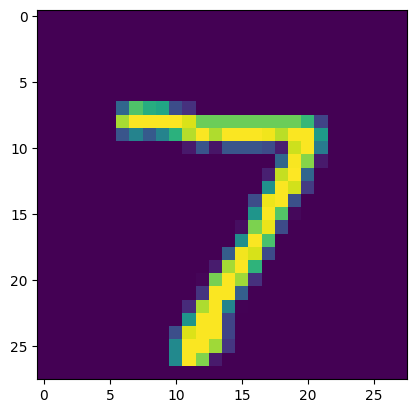

In [12]:
show_image(x, idx=0)

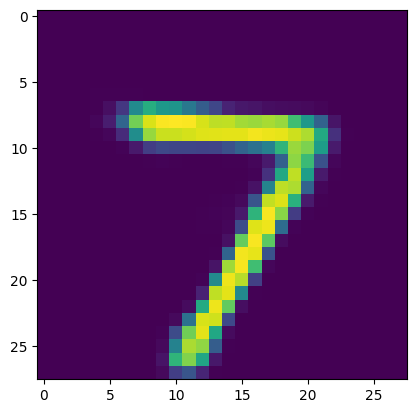

In [13]:
show_image(x_hat, idx=0)

## Generate Images

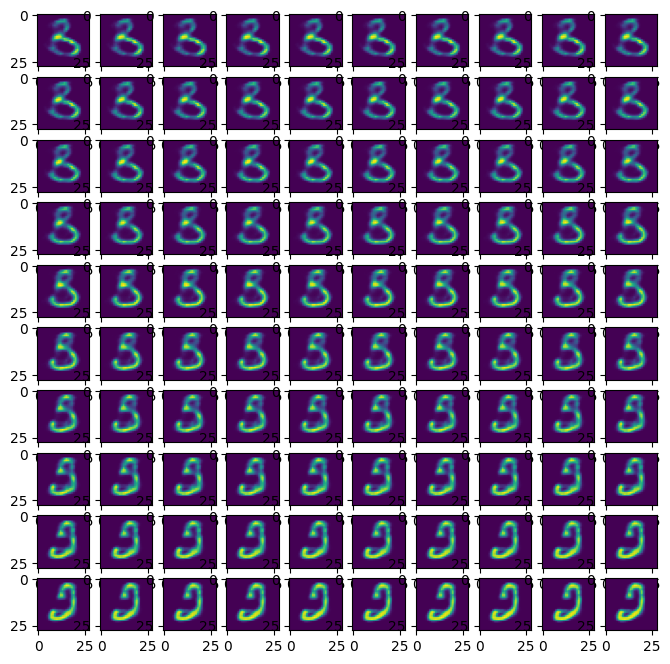

In [30]:
gen_N = 100
with torch.no_grad():
    noise1 = torch.randn(1, latent_dim).to(DEVICE) # Assumes latent vector is close to N(0, I).
    noise2 = torch.randn(1, latent_dim).to(DEVICE) # Assumes latent vector is close to N(0, I).
    noise = torch.zeros([gen_N, latent_dim]).to(DEVICE)

    alpha = 0
    alpha_inc = 1/gen_N
    for i in range(gen_N):
        noise[i,:] = alpha*noise1 + (1-alpha)*noise2
        alpha = alpha + alpha_inc

    generated_images = decoder(noise)
    rows = 10
    cols = 10
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8,8))

    for i in range(rows):
        for j in range(cols):
            if img_count < generated_images.shape[0]:
                x = generated_images[img_count]
                x = x.view(28, 28)
                axes[i, j].imshow(x.cpu().numpy())
                img_count+=1



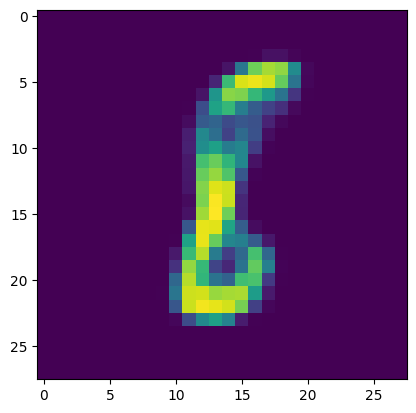

In [22]:
show_image(generated_images, idx=0)

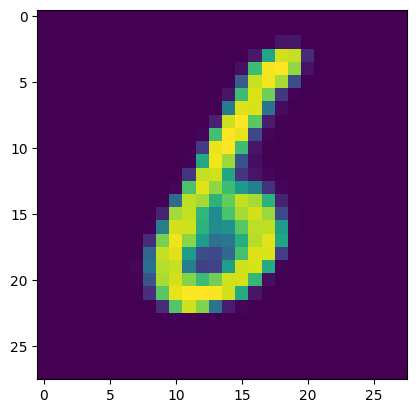

In [23]:
show_image(generated_images, idx=99)

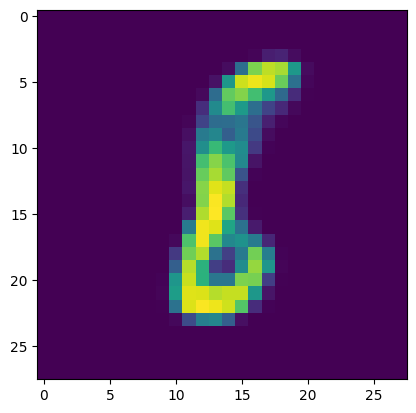

In [24]:
show_image(generated_images, idx=10)